O conjunto de dados Cora é comumente usado em tarefas de classificação de documentos. Ele é composto por citações científicas e cada documento é representado como uma bag-of-words binária. O desafio com Cora é que ele não é um modelo de embeddings de palavras, como o GloVe ou o FastText. Em vez disso, é um conjunto de dados de documentos.

Se você deseja usar o conjunto de dados Cora para criar embeddings, você terá que treinar um modelo nele. Uma abordagem popular para isso é usar o método Graph Neural Networks (GNNs) ou Graph Convolutional Networks (GCNs) para aprender representações vetoriais dos documentos.

Passos principais:

    Carregar o conjunto de dados Cora: Isso envolve carregar os documentos e o gráfico de citação.

    Treinar um GCN: Usando o gráfico de citação e os recursos dos documentos (bag-of-words binária), você pode treinar um GCN para aprender embeddings para cada documento.

    Gerar Embeddings para Títulos: Depois de treinar o GCN, você pode usá-lo para gerar embeddings para qualquer documento no conjunto de dados Cora.

Para implementar um GCN com PyTorch, você provavelmente usaria uma biblioteca como o PyTorch Geometric. Treinar um GCN é um processo mais envolvido do que simplesmente carregar embeddings pré-treinados como o GloVe.

# Instalando o PyTorch Geometric

In [ ]:
# !python -m venv pytorch
# !pytorch\Scripts\activate

# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.0.0+cu118.html

# !pip install torch-geometric

In [ ]:
# import runpy

# # Carrega as funções diretamente do arquivo pytorch_checks.py
# check_pytorch = runpy.run_path('../../../../utils/pytorch_checks.py')['check_pytorch']
# check_gpu = runpy.run_path('../../../../utils/pytorch_checks.py')['check_gpu']


In [ ]:
# import importlib.util

# # Especifique o caminho completo para o arquivo pytorch_checks.py
# path = '../../../../utils/pytorch_checks.py'

# # Carrega as funções diretamente do arquivo pytorch_checks.py
# spec = importlib.util.spec_from_file_location("pytorch_checks", path)
# pytorch_checks = importlib.util.module_from_spec(spec)
# spec.loader.exec_module(pytorch_checks)

# check_pytorch = pytorch_checks.check_pytorch
# check_gpu = pytorch_checks.check_gpu

# Avaliando instalação PyTorch e GPU

In [ ]:
import sys
sys.path.append('../../../../utils')
sys.path.append('../../../../source/adapters/input/data/')

from pytorch_checks import check_pytorch, check_gpu, try_amb, try_gpu

try_amb()
check_pytorch()
check_gpu()
!nvcc -V

# Conjunto de dados Cora
O conjunto de dados Cora é um conjunto de dados bem conhecido no campo da pesquisa de grafos. Este consiste em 2708 publicações científicas classificadas em uma das sete classes. A rede de citações consiste em 5429 links. Cada publicação no conjunto de dados é descrita por um vetor de palavra com valor 0/1 indicando a ausência/presença da palavra correspondente no dicionário. O dicionário consiste em 1433 palavras únicas.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

# Carregando o conjunto de dados Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Informações básicas sobre o conjunto de dados
print("Número de classes:", dataset.num_classes)
print("Número de recursos por nó:", dataset.num_node_features)
print("Número de nós no conjunto de treinamento:", len(dataset[0].y))
print("Número de arestas no conjunto de treinamento:", dataset[0].edge_index.shape[1])

# https://keras.io/examples/graph/gnn_citations/

label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

In [ ]:
import numpy as np
# Exibindo as classes do conjunto de dados
data = dataset[0]

unique_classes = np.unique(data.y.numpy())
print("Classes presentes no conjunto de dados Cora:")
print(unique_classes)
data.y[:15]

In [ ]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns

counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(15, 5))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

## Grafo do Cora Dataset

In [ ]:
print(f'Número de nós: {data.num_nodes}')
print(f'Número de arestas: {data.num_edges}') 

print(f'Tem nós isolados: {data.has_isolated_nodes()}') # False 
print(f'Tem auto-loops: {data.has_self_loops()}') # False 
print(f'É não direcionado: {data.is_undirected ()}') # Verdadeiro

print(f'Grau médio: {data.num_edges / data.num_nodes:.2f}') 
# Average node degree: 3.90

In [ ]:
edge_index = data.edge_index.numpy() 
print(edge_index.shape) 
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]] 
edge_example

In [ ]:
import networkx as nx

node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6)) 
G = nx.Graph() 
G.add_nodes_from(node_example) 
G.add_edges_from(list(zip(edge_example[0], edge_example[1]))) 
nx.draw_networkx(G , with_labels=False)

In [ ]:
import pandas as pd
from torch_geometric.utils import to_networkx

# import torch
# from torch import Tensor
# import torch_geometric
# from torch_geometric.datasets import Planetoid

G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(15, 5))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

In [ ]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

# Rede Neural em Grafos

## Carregando o Dataset

In [1]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

# Carregando o conjunto de dados Cora
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

## Criado a classe para o modelo com PyTorch

In [2]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from IPython.display import clear_output

# Classe de definição do modelo de Rede Neural Convolucional
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


# Função de avaliação do modelo
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out     = model(data)
        pred    = out.argmax(dim=1)
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        acc     = correct / data.test_mask.sum().item()
    return acc

# Função para plotagem iterativa do loop de aprendizado
def plot_learning_curve(train_losses, val_losses, val_accuracies):
    epochs = range(0, len(train_losses))

    plt.figure(figsize=(12, 4))

    # Plot da perda de treinamento e validação
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve - Loss')
    plt.legend()

    # Plot da acurácia de validação
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve - Validation Accuracy')
    plt.legend()

    plt.tight_layout()

In [3]:
# Atribuir o processamento para a GPU, caso disponível
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Criar a instância do modelo
model     = GCN().to(device)

# Atribuir os dados ao dispositivo
data      = dataset[0].to(device)

# Definir o otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Treinar o modelo
model.train()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

# Treinar o modelo nos dados desejados

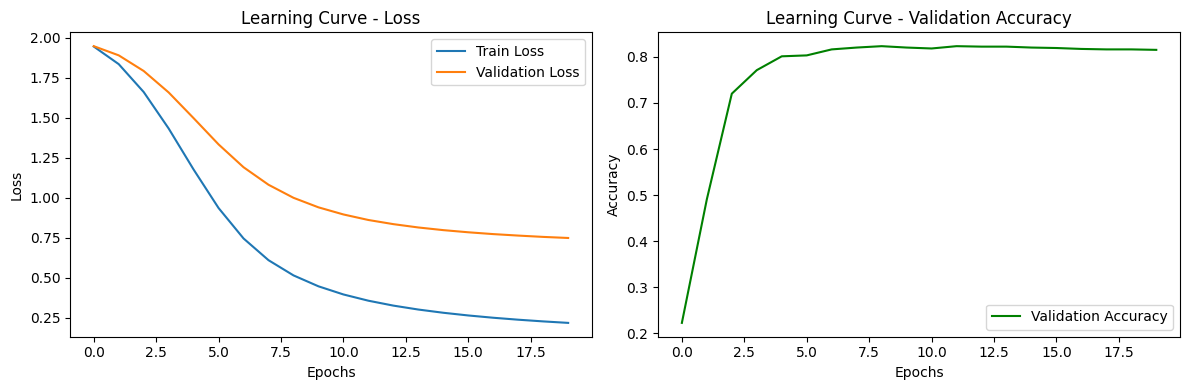

Epoch 190, Loss: 0.2183, Accuracy: 0.8150


In [4]:
import torch.nn.functional as F

train_losses   = []
val_losses     = []
val_accuracies = []

# Loop de treinamento
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Avaliar o desempenho do modelo durante o treinamento
    if epoch % 10 == 0:
        acc = evaluate(model, data)
        train_losses.append(loss.item())
        val_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
        val_losses.append(val_loss.item())
        val_accuracies.append(acc)
        
        # Plotar em tempo real
        clear_output(wait=True)
        plot_learning_curve(train_losses, val_losses, val_accuracies)
        plt.show()

        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')


In [ ]:
# train_losses = []
# val_losses = []
# val_accuracies = []

# # Loop de treinamento
# for epoch in range(600):
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()

#     # Avaliar o desempenho do modelo durante o treinamento
#     if epoch % 10 == 0:
#         acc = evaluate(model, data)
#         train_losses.append(loss.item())
#         val_loss = F.nll_loss(out[data.test_mask], data.y[data.test_mask])
#         val_losses.append(val_loss.item())
#         val_accuracies.append(acc)
        
#         # Plotar em tempo real
#         clear_output(wait=True)
#         plot_learning_curve(train_losses, val_losses, val_accuracies)
#         plt.show()

#         print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}')

In [ ]:
import torch

# Limpar a memória da GPU
torch.cuda.empty_cache()

In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Exemplo de dados
# y_true   = [0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
# y_scores = [0.1, 0.2, 0.7, 0.8, 0.6, 0.3, 0.5, 0.4, 0.9, 0.85]

# # Calcula a curva ROC e a AUC
# fpr, tpr, thresholds = roc_curve(y_true, y_scores)
# roc_auc = auc(fpr, tpr)

# # Plota a curva ROC
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc='lower right')
# plt.show()


Essa função plota a perda de treinamento e validação em um gráfico, além de uma segunda plotagem com a acurácia de validação. A separação em duas subplots permite que você visualize a evolução da perda e da acurácia de forma mais clara.

Ao analisar a curva de aprendizado, observa-se os seguintes pontos:

    Perda de Treinamento e Validação: 
    
    - Uma perda de treinamento muito baixa em comparação com a perda de validação pode indicar overfitting, enquanto uma perda alta em ambos os casos pode indicar underfitting.

    Acurácia de Validação: 
    
    - Uma curva de acurácia crescente indica que o modelo está aprendendo e melhorando. Uma estagnação ou queda na acurácia de validação pode indicar overfitting.

A interpretação da curva de aprendizado pode variar dependendo da natureza do problema, dos dados e da configuração do modelo. Portanto, é importante analisar a curva com cuidado e fazer ajustes conforme necessário.

Mas, em linhas gerais, um bom aprendizado para o modelo é caracterizado por um comportamento específico nas curvas de aprendizado ao longo das épocas. Aqui estão os padrões que você deve observar para determinar se o seu modelo está aprendendo de maneira adequada:

1. **Perda de Treinamento e Validação:**
   - A perda de treinamento deve diminuir consistentemente ao longo das épocas. Isso indica que o modelo está se ajustando aos dados de treinamento e melhorando a sua capacidade de fazer previsões precisas.
   - A perda de validação deve diminuir inicialmente, mas pode começar a se estabilizar ou até mesmo aumentar ligeiramente. Isso é esperado à medida que o modelo começa a se ajustar aos detalhes específicos do conjunto de treinamento e pode começar a generalizar menos bem para dados novos. No entanto, uma diferença significativa entre a perda de treinamento e a perda de validação indica overfitting, enquanto valores altos para ambas podem indicar underfitting.

2. **Acurácia de Validação:**
   - A acurácia de validação deve aumentar consistentemente à medida que o modelo aprende a fazer previsões melhores.
   - Assim como a perda de validação, a acurácia pode começar a se estabilizar ou aumentar mais lentamente à medida que o modelo se ajusta aos dados de treinamento.
   - Se a acurácia de treinamento continuar a aumentar enquanto a acurácia de validação começa a cair ou se estabiliza, isso sugere overfitting, pois o modelo está se tornando muito especializado nos dados de treinamento.

Em resumo, um bom aprendizado é caracterizado por uma perda de treinamento em queda, uma perda de validação que diminui inicialmente e depois se estabiliza, e uma acurácia de validação crescente. É importante observar a relação entre a perda de treinamento e a perda de validação, bem como a taxa de crescimento da acurácia de validação, para avaliar se o modelo está encontrando um bom equilíbrio entre aprender com os dados de treinamento e generalizar para dados novos.

# Fazer classificações com dados novos

In [7]:
import sys
sys.path.append('../../../../utils')
sys.path.append('../../../../source/adapters/input/data/')

import os
from cnpq_classes import *

pasta_arquivo = "C:/Users/marco/fioce/source/adapters/input/data/"
os.listdir(pasta_arquivo)

['capes_areas-de-conhecimento.pdf',
 'cnpq_tabela-areas-conhecimento.pdf',
 'fioce_colaboradores-2023.xls',
 'fioce_producao_2008.01-2023.06.xlsx',
 'fiocruz_unidade-desconhecida.xlsx',
 'Impact-Factor-2023.pdf',
 'lista_orientadores_funcap_2023.csv',
 'sucupira_todas_as_areas_avaliacao1672761192111.csv']

In [8]:
arquivo = 'cnpq_tabela-areas-conhecimento.pdf'
caminho = pasta_arquivo+arquivo
df_areas = extrair_areas(caminho)

Processando páginas do PDF das Áreas de pesquisa do CNPq..:   0%|          | 0/21 [00:00<?, ?it/s]

Total dos códigos   identificados: 1285
Total de descrições identificadas: 1285
Nenhum erro de códigos em descrições!
144 possíveis erros de descrição detectados.


Corrigindo descrições...:   0%|          | 0/1285 [00:00<?, ?it/s]

In [9]:
df_areas

,Codigo,Descricao
0,1.00.00.00-3,Ciências Exatas e da Terra
1,1.01.00.00-8,Matemática
2,1.01.01.00-4,Álgebra
3,1.01.01.01-2,Conjuntos
4,1.01.01.02-0,Lógica Matemática
...,...,...
1280,8.03.08.02-3,Roteiro e Direção Cinematográficos
1281,8.03.08.03-1,Técnicas de Registro e Processamento de Filmes
1282,8.03.08.04-0,Interpretação Cinematográfica
1283,8.03.09.00-3,Artes do Vídeo


In [ ]:
# levels = df_areas['Codigo'].str.count("\.").iloc[0]  # conta a quantidade de pontos, para determinar o número de níveis
# unique_counts = [count_unique_for_level(i) for i in range(levels)]
# unique_counts.append(count_unique_for_last_level())

# qte_grandeareas, qte_areas, qte_subareas, qte_especialidades = unique_counts
# print(f'Quantidades de codigos:')
# print(f'  Grande_Área: {qte_grandeareas:2}')
# print(f'         Área: {qte_areas:2}')
# print(f'      Subárea: {qte_subareas:2}')
# print(f'Especialidade: {qte_especialidades:2}')

# Dividir a coluna 'Codigo' no ponto '.' gerando as subdivisões
df_split = df_areas['Codigo'].str.split('.', expand=True)

# Parte do código referente à classificação na grande área
n1_area = df_split.iloc[:, -1] = df_split.iloc[:, 0].str.split('-').str[0]

# Parte do código referente à classificação na subárea da área
n2_area = df_split.iloc[:, -1] = df_split.iloc[:, 1].str.split('-').str[0]

# Parte do código referente à classificação na subárea da área
n3_subarea = df_split.iloc[:, -1] = df_split.iloc[:, 2].str.split('-').str[0]

# Remover o último hífen e apresentar especialidade
n4_especialidade = df_split.iloc[:, -1] = df_split.iloc[:, 3].str.split('-').str[0]

In [ ]:
import torch
import torch_geometric.transforms as T
from torch_geometric.data import Data

def preprocess_data(title, abstract, keywords):
    # Aqui você deve realizar o pré-processamento dos títulos, resumos e palavras-chave.
    # Pode envolver tokenização, remoção de stopwords, etc.
    # Transforme os dados em tensores PyTorch conforme necessário.

    # Exemplo de pré-processamento simples:
    # text = title + ' ' + abstract + ' ' + keywords
    # tokens = tokenize_and_preprocess(text)
    # Converta os tokens em tensores PyTorch

    # Crie um objeto Data para usar com o modelo
    # Aqui, você pode precisar criar edge_index, x (recursos) e outros atributos
    data = Data(x=your_features_tensor, edge_index=your_edge_index_tensor)
    
    return data

def classify_data(model, title, abstract, keywords):
    # Preprocessar os dados
    data = preprocess_data(title, abstract, keywords)
    
    # Executar o modelo para fazer previsões
    model.eval()
    with torch.no_grad():
        out = model(data)
    
    # As previsões estarão em 'out'
    return out

# Exemplo de uso
# Substitua 'your_model' pelo seu modelo treinado e forneça os títulos, resumos e palavras-chave
title = "Sample title"
abstract = "This is a sample abstract for testing."
keywords = "sample, abstract, testing"
predictions = classify_data(your_model, title, abstract, keywords)
print(predictions)

In [ ]:
def get_vector(title):
    # Aqui, o processo é mais complicado, pois você precisa converter seu título em um formato aceitável pelo modelo
    # e depois passá-lo pelo GCN para obter um embedding. 
    pass

Se você deseja treinar o modelo do zero com seus próprios dados, você precisará seguir algumas etapas adicionais. Aqui está um guia geral sobre como treinar um modelo de classificação usando PyTorch Geometric com seus próprios dados:

1. **Preparação dos Dados:**
   - Carregue seus dados textuais (títulos, resumos, palavras-chave) e rotulados em um formato adequado (dataframes do pandas, listas de dicionários, etc.).
   - Realize o pré-processamento dos textos, que pode incluir tokenização, remoção de stopwords, vetorização (por exemplo, usando TF-IDF ou incorporações de palavras) e conversão para formatos de tensores do PyTorch.

2. **Construção do Grafo:**
   - Construa um grafo que represente as relações entre os dados. Isso pode envolver a criação de nós para documentos e palavras-chave, bem como a criação de arestas para representar associações entre eles.

3. **Definição do Modelo:**
   - Crie uma classe para o seu modelo, que estenderá `torch.nn.Module`.
   - Defina as camadas do seu modelo, incluindo camadas de convolução (GCN ou outras), camadas de ativação e camadas de saída.

4. **Preparação dos Dados para PyTorch Geometric:**
   - Converta seus dados em objetos `Data` do PyTorch Geometric. Isso envolve a criação de tensores para os recursos dos nós, os índices das arestas e os rótulos dos nós.

5. **Divisão dos Dados:**
   - Divida seus dados em conjuntos de treinamento, validação e teste.
   - Atribua máscaras aos nós para indicar quais nós pertencem a cada conjunto.

6. **Treinamento do Modelo:**
   - Defina uma função de perda (por exemplo, perda de entropia cruzada) e um otimizador (por exemplo, Adam).
   - Execute um loop de treinamento em várias épocas, alimentando o modelo com os dados de treinamento e atualizando os pesos com base na função de perda.

7. **Avaliação do Modelo:**
   - Avalie o desempenho do modelo nos conjuntos de validação e teste usando métricas apropriadas, como acurácia, F1-score, AUC-ROC etc.

8. **Ajuste e Otimização:**
   - Ajuste os hiperparâmetros do modelo e da otimização, como taxa de aprendizado, tamanho das camadas, número de camadas, etc.
   - Use a avaliação nos conjuntos de validação para guiar o ajuste dos hiperparâmetros.

9. **Teste Final:**
   - Avalie o modelo no conjunto de teste para obter uma estimativa final do seu desempenho.

10. **Implantação e Uso:**
   - Use o modelo treinado para fazer previsões em novos dados não rotulados.

Lembre-se de que o processo de treinamento de modelos de aprendizado de máquina é iterativo e pode envolver várias tentativas e ajustes para obter o melhor desempenho. Certifique-se de acompanhar as métricas de avaliação e iterar conforme necessário para melhorar o seu modelo.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Divisão dos dados em conjuntos
train_dataset = MyDataset(train_data, train_labels)
val_dataset = MyDataset(val_data, val_labels)
test_dataset = MyDataset(test_data, test_labels)

# Criação de dataloaders para carregar os dados durante o treinamento
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
